# Bank Marketing Campaign

The dataset consists of two main feature groups:

1. Customer Profile
    - age: The age of the customer.
    - job: The customer's occupation.
    - balance: The customer's account balance.
    - housing: Whether the customer has a housing loan (yes/no).
    - loan: Whether the customer has a personal loan (yes/no).

2. Marketing Data
    - contact: The type of communication used to contact the customer.
    - month: The last month of the year in which the customer was contacted.
    - campaign: The number of contacts made during the current campaign for this customer.
    - pdays: The number of days since the customer was last contacted in the previous campaign.
    - poutcome: The outcome of the previous marketing campaign (e.g., success or failure).
    - deposit: Whether the customer made a term deposit or not. (target variable)
   

## Background

In the competitive banking industry, financial institutions strive to attract and retain customers efficiently. One of the key banking products is term deposits, which provide customers with a secure investment option while ensuring stable funding for the bank. However, not all customers are equally likely to invest in term deposits, making it crucial for banks to identify potential customers and target them with effective marketing campaigns.

Traditional marketing approaches often involve reaching out to a broad audience, which can be costly and inefficient. With the increasing availability of customer data, banks can now leverage data-driven models to predict which customers are most likely to subscribe to a term deposit.

This study utilizes customer profile data (age, occupation, account balance, loan status) and marketing interaction data (contact method, campaign frequency, past campaign outcomes) to understand customer preferences. By identifying key factors influencing customer decisions, banks can:
- Improve targeted marketing strategies
- Reduce unnecessary marketing costs
- Increase customer engagement
- Enhance the success rate of term deposit acquisitions

In [1]:
#Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# To ignores the warnings
import warnings
warnings.filterwarnings('ignore')
import missingno

C:\Users\giova\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.base import TransformerMixin, BaseEstimator

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score, roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Imbalance Dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
df = pd.read_csv('data_bank_marketing_campaign.csv')
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


## Data Understanding & Cleaning

In [4]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,75,"[72, 57]"
1,job,object,0,0.0,12,"[entrepreneur, unemployed]"
2,balance,int64,0,0.0,3153,"[4642, 13]"
3,housing,object,0,0.0,2,"[yes, no]"
4,loan,object,0,0.0,2,"[yes, no]"
5,contact,object,0,0.0,3,"[telephone, cellular]"
6,month,object,0,0.0,12,"[mar, jan]"
7,campaign,int64,0,0.0,32,"[63, 14]"
8,pdays,int64,0,0.0,422,"[251, 690]"
9,poutcome,object,0,0.0,4,"[unknown, success]"


<Axes: >

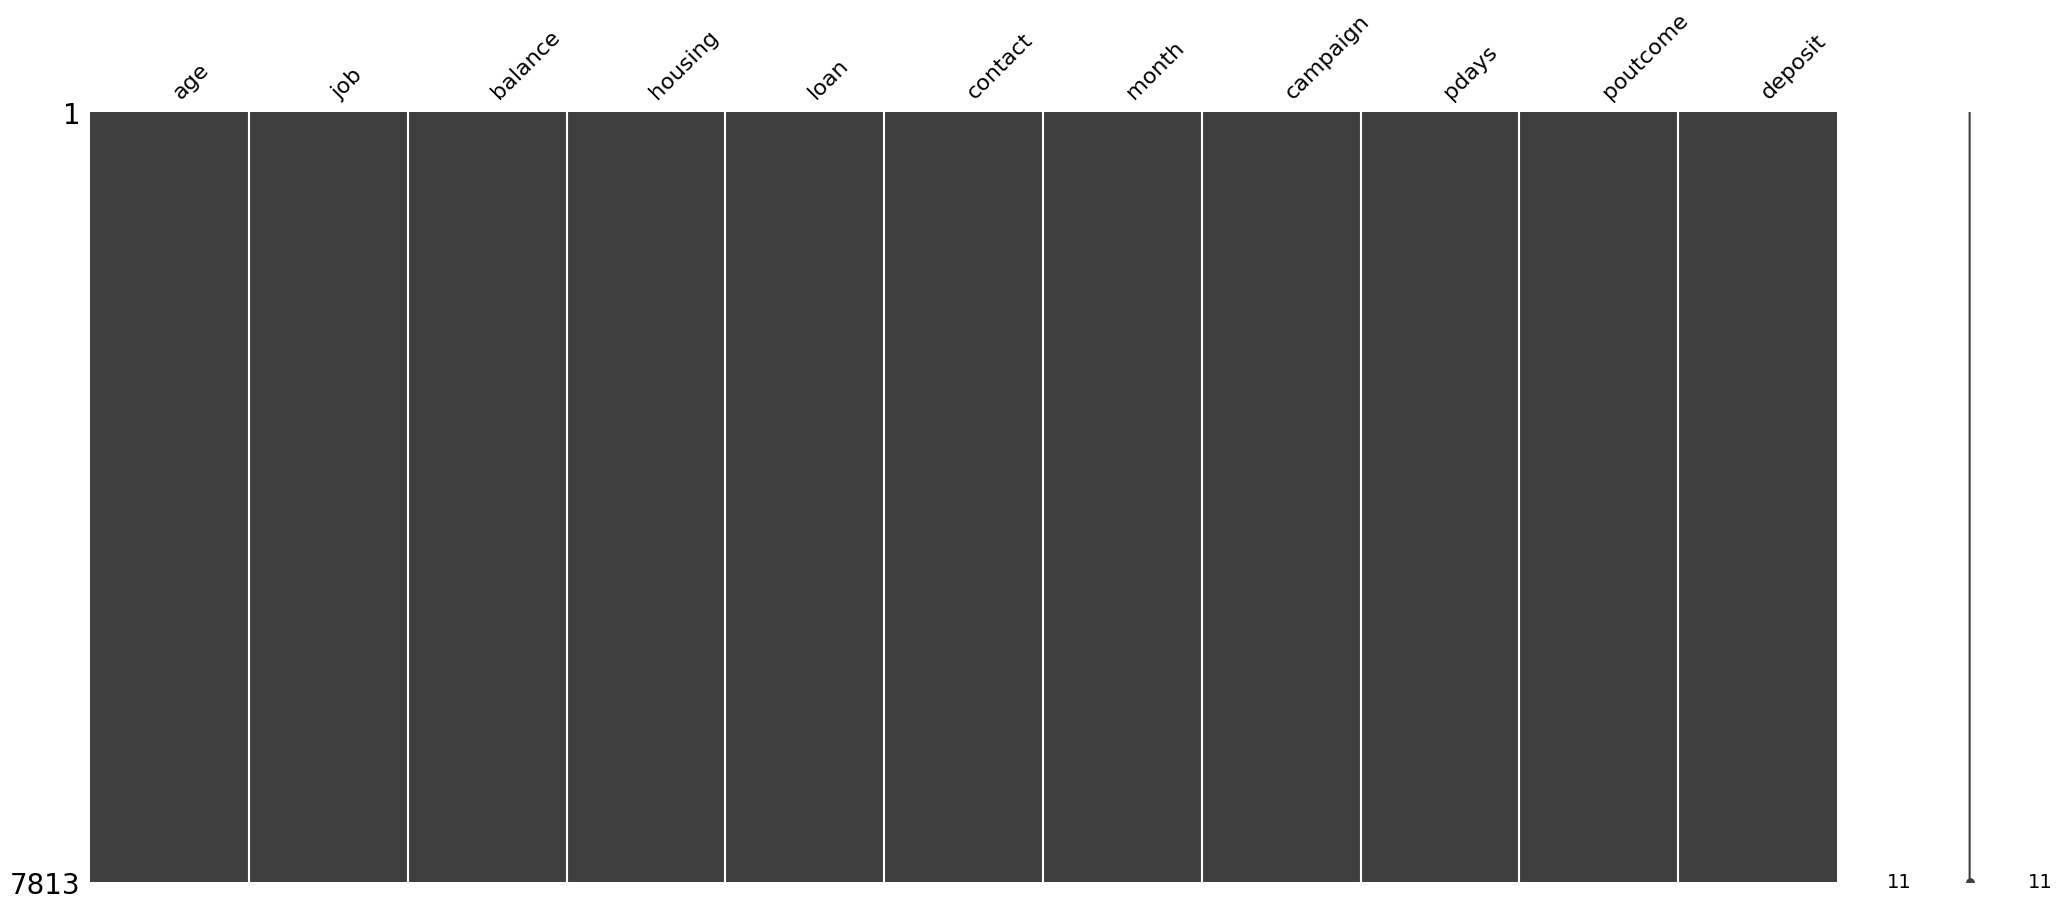

In [6]:
missingno.matrix(df)

In [7]:
def group_cols_by_dtype(df):
    num_cols, cat_cols, dt_cols, bool_cols = [], [], [], []
    
    num_cols.append(df.select_dtypes(include=['int', 'float']).columns.to_list())
    cat_cols.append(df.select_dtypes(include=['object', 'category']).columns.to_list())
    dt_cols.append(df.select_dtypes(include=['datetime']).columns.to_list())
    bool_cols.append(df.select_dtypes(include=['bool']).columns.to_list())
    
    return num_cols, cat_cols, dt_cols, bool_cols

num_cols, cat_cols, dt_cols, bool_cols = group_cols_by_dtype(df)

In [8]:
def histogram_num_features(df):
    print("Histogram for Numerical Features")
    df[num_cols[0][:-1]].hist(figsize = (20,10), bins=50);
    plt.show();

In [9]:
def boxplot_num_features(df):
    print("Box Plot for Numerical Features")
    for col in num_cols[0][:-1]:
        df[col].plot(kind = 'box');
        plt.show();

Histogram for Numerical Features


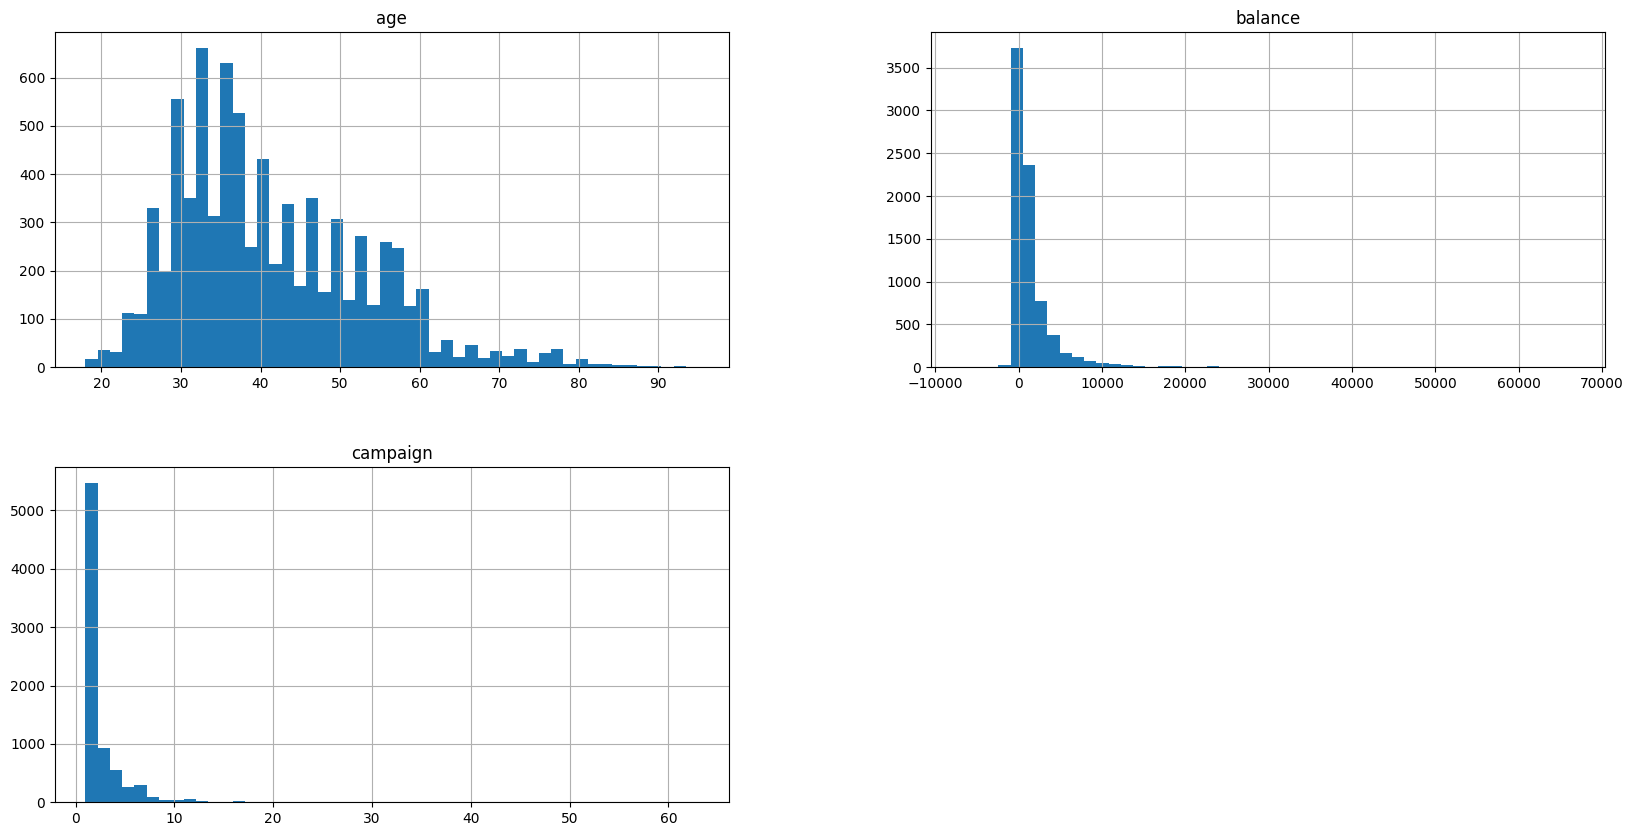

In [10]:
histogram_num_features(df)

Box Plot for Numerical Features


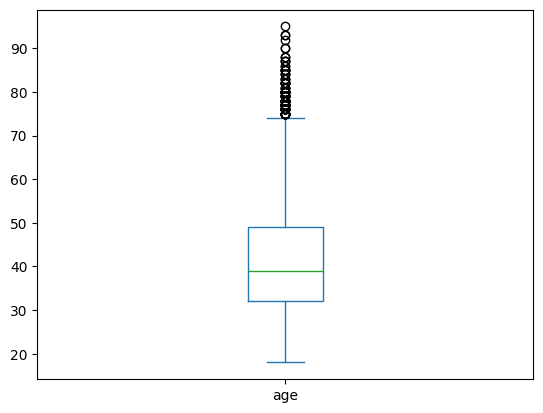

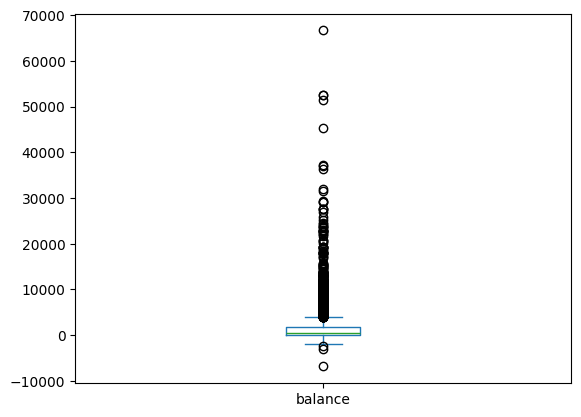

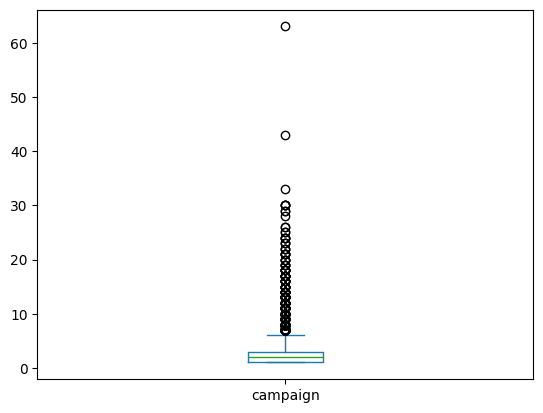

In [11]:
boxplot_num_features(df)

In [12]:
# Function to identify outliers
def find_outliers(data):
    q1 = np.percentile(data, 25)  # First quartile (25th percentile)
    q3 = np.percentile(data, 75)  # Third quartile (75th percentile)
    iqr = q3 - q1  # Interquartile Range (IQR)
    print(f'IQR: {iqr}')

    lower_limit = q1 - 1.5 * iqr  # Lower bound for outliers
    upper_limit = q3 + 1.5 * iqr  # Upper bound for outliers
    outliers = data[(data < lower_limit) | (data > upper_limit)]  # Identify outliers
    
    minimal=data.min()
    maximal=data.max()
    print(f'Min: {minimal}')
    print(f'Max: {maximal}')
    print(f'Lower Limit: {lower_limit}') 
    print(f'Upper Limit: {upper_limit}') 
    print(f'Number of outliers: {len(outliers)}')

In [13]:
for i in num_cols[0]:
    print('Feature:',i)
    find_outliers(df[i])
    print('=======================')

Feature: age
IQR: 17.0
Min: 18
Max: 95
Lower Limit: 6.5
Upper Limit: 74.5
Number of outliers: 121
Feature: balance
IQR: 1557.0
Min: -6847
Max: 66653
Lower Limit: -2208.5
Upper Limit: 4019.5
Number of outliers: 736
Feature: campaign
IQR: 2.0
Min: 1
Max: 63
Lower Limit: -2.0
Upper Limit: 6.0
Number of outliers: 429
Feature: pdays
IQR: 41.0
Min: -1
Max: 854
Lower Limit: -62.5
Upper Limit: 101.5
Number of outliers: 1454


After analyzing outliers and the numerical properties of the data, I decided to apply the following filtering criteria:

- Age: I removed entries where age exceeds 74.5 to exclude extreme values beyond the upper limit.
- Balance: I retained only records where balance falls between -2208.5 and 4019.5, ensuring that extreme negative and excessively high values are removed.
- Campaign: I kept all records where campaign is ≤ 63, as the upper limit does not indicate significant anomalies.

I did not apply filtering on pdays because it contains a value of -1, which likely represents a special category (e.g., customers who were never contacted before). Removing this value could lead to unintended data loss and affect the model’s ability to learn from this important feature.

In [14]:
# Filtering data 
df = df[(df['age'] <= 74.5)]
df = df[(df['balance'] <= 4019.5) & (df['balance'] > -2208.5)]
df = df[(df['campaign'] <= 63)]

In [15]:
for col in cat_cols[0]:
    print("Distribution of", col)
    display(pd.DataFrame(df[col].value_counts()))

Distribution of job


,count
job,
management,1571
blue-collar,1250
technician,1159
admin.,871
services,615
retired,379
self-employed,253
unemployed,233
student,227


Distribution of housing


,count
housing,
no,3609
yes,3372


Distribution of loan


,count
loan,
no,6004
yes,977


Distribution of contact


,count
contact,
cellular,5035
unknown,1524
telephone,422


Distribution of month


,count
month,
may,1824
aug,978
jul,976
jun,779
apr,586
nov,527
feb,474
oct,240
jan,201


Distribution of poutcome


,count
poutcome,
unknown,5237
failure,756
success,650
other,338


Distribution of deposit


,count
deposit,
no,3753
yes,3228


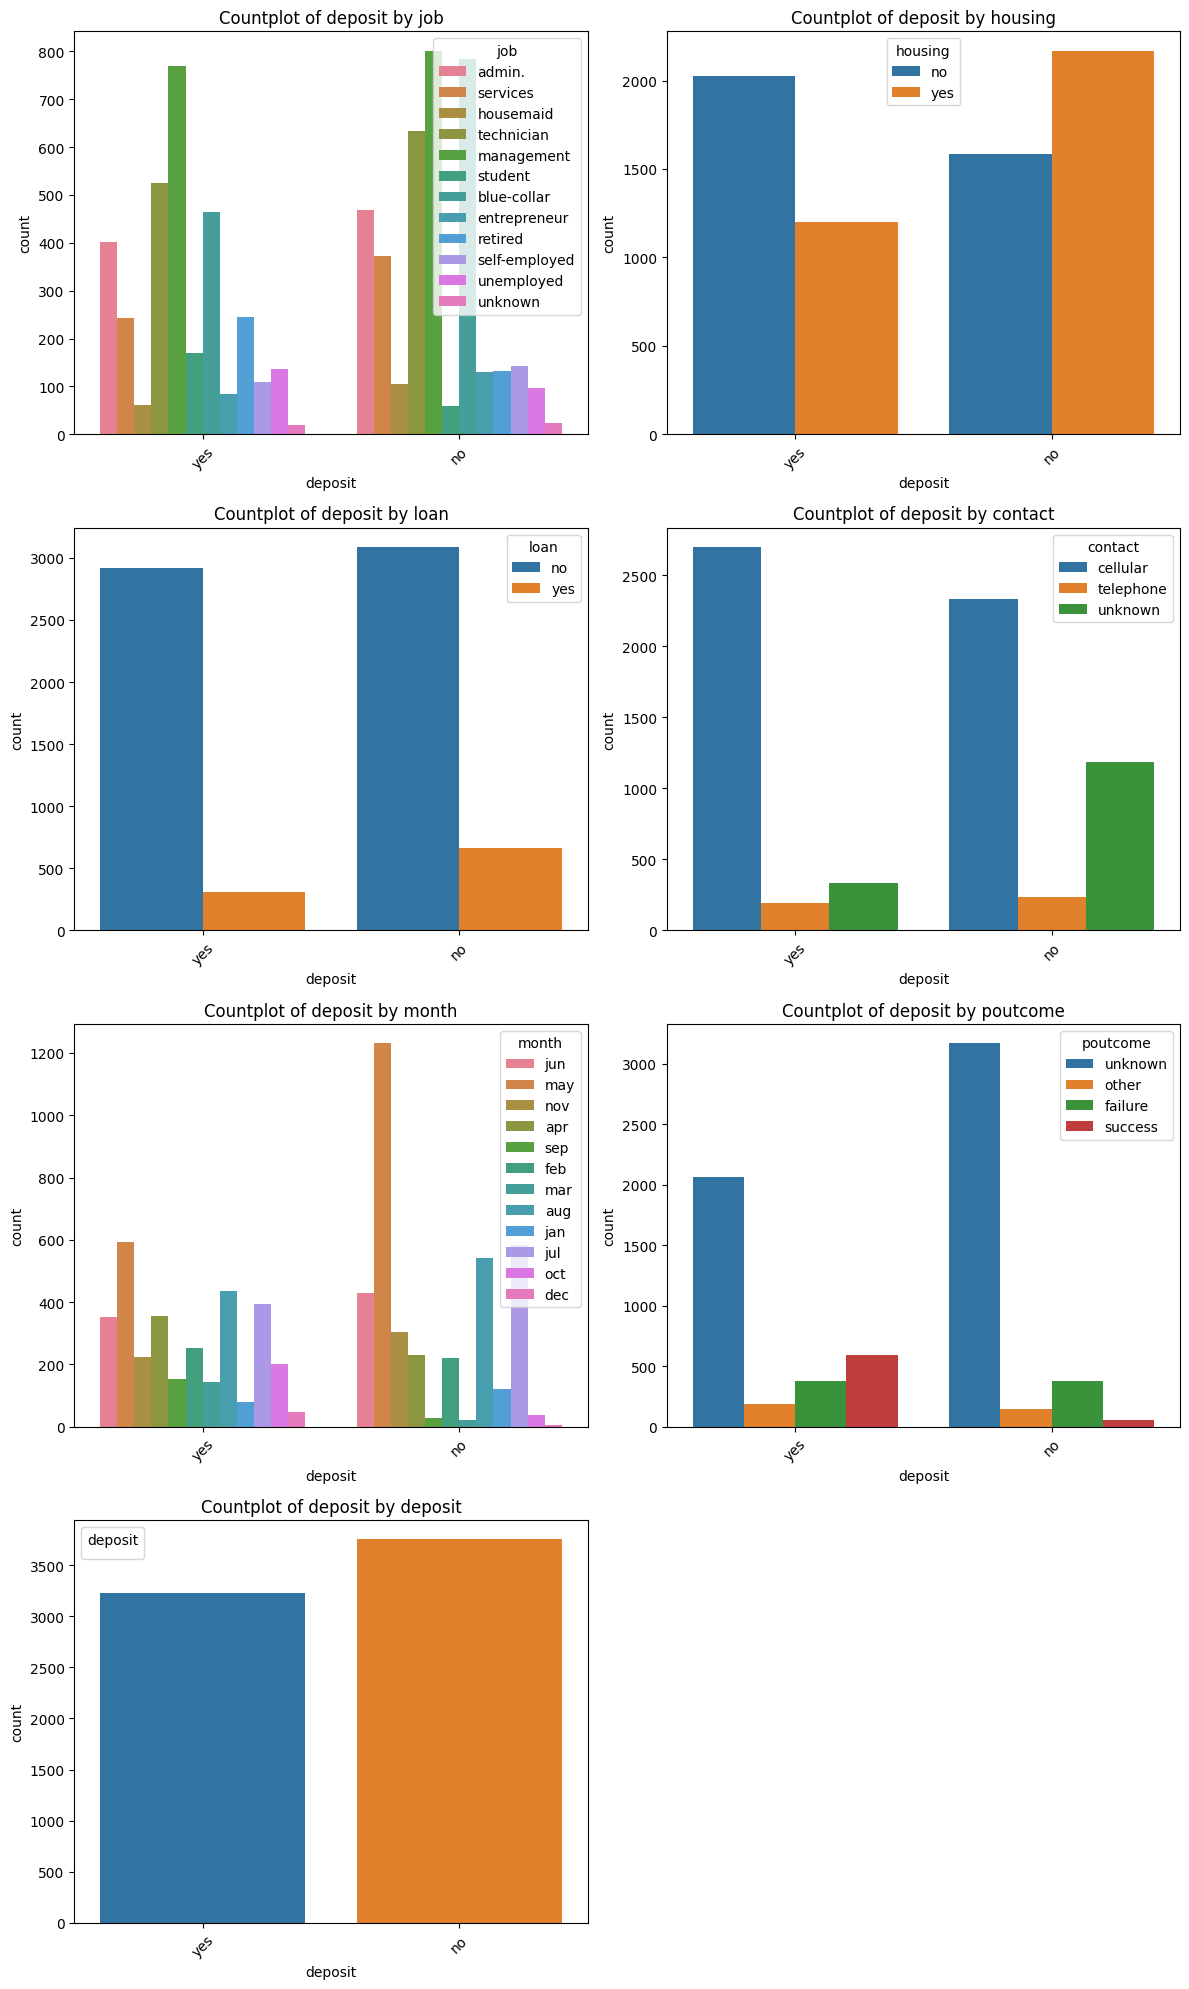

In [16]:
# Determine the number of subplots based on the number of categories
n_cols = 2  # Number of columns in the grid
n_rows = -(-len(cat_cols[0]) // n_cols)  # Calculate the required number of rows (ceiling division)

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()  # Flatten the 2D array into 1D for easier iteration

# Iterate through categorical columns and create countplots
for i, col in enumerate(cat_cols[0]):
    sns.countplot(x='deposit', hue=col, data=df, ax=axes[i])  # Generate countplot for each category
    axes[i].set_title(f'Countplot of deposit by {col}')  # Set title for the subplot
    axes[i].legend(title=col)  # Add legend for clarity
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Remove empty subplots if the number of categories is not even
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plots

In [17]:
# crosscheck the features
listItem = []

for col in df.columns:
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col]))*100, 2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

df_desc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
df_desc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,57,"[20, 53]"
1,job,object,0,0.0,12,"[entrepreneur, student]"
2,balance,int64,0,0.0,2515,"[2388, 3243]"
3,housing,object,0,0.0,2,"[yes, no]"
4,loan,object,0,0.0,2,"[yes, no]"
5,contact,object,0,0.0,3,"[cellular, unknown]"
6,month,object,0,0.0,12,"[dec, jun]"
7,campaign,int64,0,0.0,31,"[26, 21]"
8,pdays,int64,0,0.0,408,"[81, 251]"
9,poutcome,object,0,0.0,4,"[unknown, success]"


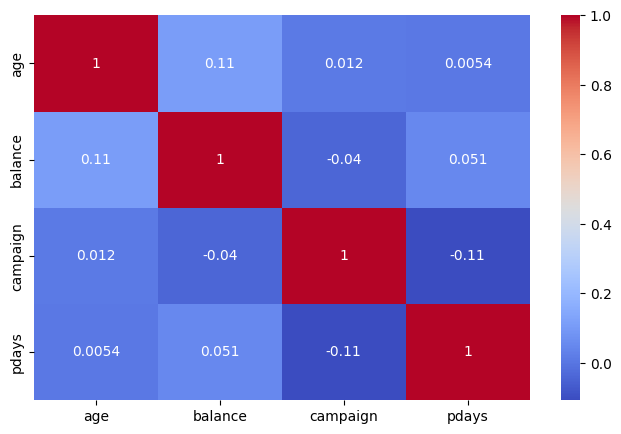

In [18]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Create a heatmap of correlations
plt.figure(figsize=(8, 5))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2g', cmap='coolwarm')

plt.show()

After analyzing the four numerical columns, none of them exhibit high correlation—all correlations are low.

## Data Preparation

In [19]:
# Check clean dataset
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no
5,41,admin.,-76,yes,no,cellular,apr,1,-1,unknown,no


This data preparation pipeline cleans, transforms, and encodes the dataset before training a machine learning model. It consists of two main components: a preprocessing function and a ColumnTransformer pipeline.

1. Preprocessing Function (preprocess)
    - Month Conversion & Cyclic Encoding: Converts categorical months into numerical values (1–12) and applies sin/cos encoding to preserve cyclic relationships.
    - Job Category Grouping:
    Jobs with fewer than 250 occurrences are grouped as "other".
    Job categories are further generalized into broader groups (e.g., "Office & Managerial Jobs", "Physical & Service Jobs").
    - Handling pdays:
    Creates a new binary feature not_contacted (1 if the client was never contacted).
    Replaces pdays = -1 with the maximum pdays value.
    - Binary Encoding: Converts housing and loan features from "yes"/"no" to 1/0.
2. Column Transformer (preprocessor)
    - Numerical Features (age, balance, campaign, pdays, month_sin, month_cos)
    Imputation: Replaces missing values with the median.
    Scaling: Applies StandardScaler for normalization.
    - Categorical Features (job, contact, poutcome)
    Imputation: Replaces missing values with the most frequent value.
    Encoding: Applies One-Hot Encoding, ignoring unknown categories.
    Binary Features (housing, loan, not_contacted)
    Passed through without transformation.
3. Full Processing Pipeline (transformer)
    - Applies preprocessing transformations first.
    - Ensures the final output remains a DataFrame using a custom DataFrameTransformer.

This structured pipeline ensures the dataset is cleaned, transformed, and ready for machine learning models, preserving important patterns while handling missing data, encoding categorical variables, and normalizing numerical features.

**Custom Transformer**

This custom transformer is designed to convert the output of a ColumnTransformer into a DataFrame. By doing so, it ensures that the transformed dataset retains its feature names and indexing, making it easier to interpret and use in subsequent steps.

In [20]:
class DataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        X_t = self.transformer.transform(X)
        columns = self.transformer.get_feature_names_out()
        return pd.DataFrame(X_t, columns=columns, index=X.index)


**Preprocessing Function**

This function performs several preprocessing steps:

- Converts month names into numerical values and applies cyclic encoding to capture temporal relationships.
- Groups minor job categories into a single "other" category for better generalization.
- Introduces a new feature 'not_contacted' to indicate whether a customer has never been contacted before.
- Encodes binary categorical features ('housing' and 'loan') into numerical format.
- Maps job categories into broader groups, making them more interpretable.

In [21]:
def preprocess(df):
    df = df.copy()  # Avoid SettingWithCopyWarning

    # Map month names to numerical values
    month_mapping = {
        "jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
        "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12
    }
    df['month'] = df['month'].map(month_mapping)

    # Apply cyclic encoding for the 'month' feature
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Merge minor job categories into "other"
    threshold = 250
    job_counts = df['job'].value_counts()
    minor_jobs = job_counts[job_counts < threshold].index.tolist()
    df['job'] = df['job'].apply(lambda x: 'other' if x in minor_jobs else x)

    # Create a new column 'not_contacted' based on 'pdays'
    df['not_contacted'] = (df['pdays'] == -1).astype(int)
    df['pdays'] = df['pdays'].replace(-1, df['pdays'].max())

    # Encode binary categorical features
    df[['housing', 'loan']] = df[['housing', 'loan']].replace({'yes': 1, 'no': 0})

    # Map job titles into broader categories
    job_mapping = {
        "management": "Office & Managerial Jobs",
        "admin.": "Office & Managerial Jobs",
        "technician": "Office & Managerial Jobs",
        "blue-collar": "Physical & Service Jobs",
        "services": "Physical & Service Jobs",
        "housemaid": "Physical & Service Jobs",
        "self-employed": "Self-Employed & Entrepreneurs",
        "entrepreneur": "Self-Employed & Entrepreneurs",
        "retired": "Unemployed / Retired",
        "unemployed": "Unemployed / Retired",
        "student": "Unemployed / Retired",
        "unknown": "Unknown"
    }
    df['job'] = df['job'].replace(job_mapping)

    return df

**Preprocessing Pipeline**

In [22]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), ['age', 'balance', 'campaign', 'pdays', 'month', 'month_sin', 'month_cos']),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), ['job', 'contact', 'poutcome']),
    
    ('binary', 'passthrough', ['housing', 'loan', 'not_contacted'])
])

transformer = Pipeline([
    ('preprocess', FunctionTransformer(preprocess, validate=False)),  # Initial preprocessing
    ('transform', DataFrameTransformer(preprocessor))  # Convert transformed data to DataFrame
])

**X-Y variables**

In [23]:
X = df.drop(columns=['deposit'])

# Convert target variable (y) from 'yes'/'no' to 1/0
encoder = LabelEncoder()
y = pd.Series(encoder.fit_transform(df['deposit']))

In [24]:
# Splitting training and test data with a proportion of 80:20
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=42)

In [25]:
# Transform
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

## Model Selection & Training

### Model Benchmarking

In [26]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier(verbose=-1)

In [27]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model_cv=cross_val_score(i,X_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

results_df=pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std})
results_df = results_df.set_index('model').sort_values(by='mean roc_auc',ascending=False)
    
# Menampilkan tabel hasil
print("\n🔹 Model Performance Based on ROC-AUC Score:")
print(results_df)


🔹 Model Performance Based on ROC-AUC Score:
                     mean roc_auc      sdev
model                                      
LightGBM                 0.766276  0.013900
XGBoost                  0.754751  0.010024
Random Forest            0.752033  0.009203
Logistic Regression      0.745525  0.013093
KNN                      0.725604  0.012551
Decision Tree            0.621472  0.016014


In [28]:
score_roc_auc = []

# Loop untuk melatih dan mengevaluasi setiap model
for idx, (model, model_name) in enumerate(zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','XGBoost', 'LightGBM'])):
    # Melatih model
    model.fit(X_train, y_train)

    # Melakukan prediksi
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilitas untuk kelas positif
    
    # Menyimpan skor ROC-AUC
    score_roc_auc.append(roc_auc_score(y_test, y_pred_proba))
    
    # Menampilkan laporan klasifikasi
    print(f"{model_name}:\n", classification_report(y_test, y_pred))

# Menampilkan hasil dalam DataFrame
results_df = pd.DataFrame({'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
                           'ROC-AUC Score': score_roc_auc})
results_df = results_df.set_index('Model').sort_values(by='ROC-AUC Score', ascending=False)

# Menampilkan tabel hasil
print("\n🔹 Model Performance Based on ROC-AUC Score:")
print(results_df)


Logistic Regression:
               precision    recall  f1-score   support

           0       0.67      0.74      0.70       751
           1       0.66      0.59      0.62       646

    accuracy                           0.67      1397
   macro avg       0.66      0.66      0.66      1397
weighted avg       0.67      0.67      0.66      1397

KNN:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68       751
           1       0.63      0.62      0.63       646

    accuracy                           0.66      1397
   macro avg       0.65      0.65      0.65      1397
weighted avg       0.66      0.66      0.66      1397

Decision Tree:
               precision    recall  f1-score   support

           0       0.64      0.47      0.54       751
           1       0.53      0.69      0.60       646

    accuracy                           0.57      1397
   macro avg       0.58      0.58      0.57      1397
weighted avg       0.59      0

After performing benchmarking, it was found that LightGBM (LGBMClassifier) is the best model based on cross-validation results and test set evaluation.

The benchmarking process involved comparing multiple classifiers, including:

- Logistic Regression (LogReg) – A linear model often used as a baseline.
- K-Nearest Neighbors (KNN) – A distance-based model that works well for small datasets but can be computationally expensive for large ones.
- Decision Tree (DT) – A simple but interpretable model that can easily overfit.
- Random Forest (RF) – An ensemble of decision trees that improves robustness and accuracy.
- XGBoost (XGB) – A powerful gradient boosting algorithm known for high predictive performance.
- LightGBM (LGBM) – A gradient boosting model optimized for efficiency and speed.

Among these models, LightGBM achieved the highest performance in terms of the evaluation metrics used, both in cross-validation and on the test set. This suggests that LightGBM is the most suitable model for this dataset and problem.

### Handling Class Imbalance

Next, the model is evaluated to determine whether applying Random OverSampling (ROS) improves its performance. Since the main goal is maximizing customer acquisition, higher recall is prioritized to ensure more potential subscribers are identified. LightGBM is trained and evaluated with and without ROS using cross-validation and test set evaluation, comparing key metrics such as accuracy, ROC-AUC, F1-score, precision, and recall. The results will determine whether oversampling enhances model performance, particularly in recall, to justify its use.

In [29]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import RandomOverSampler

lgbm = LGBMClassifier(verbose=-1)

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

# Setup Stratified K-Fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline with Random OverSampling (ROS)
pipeline_with_ros = imbPipeline([
    ('ros', RandomOverSampler(sampling_strategy='auto', random_state=42)),  
    ('model', lgbm)  
])

# Cross-validation with ROS
cv_scores_ros = cross_validate(pipeline_with_ros, X_train, y_train, cv=skfold, scoring=scoring)

# Cross-validation without ROS (only model)
cv_scores_no_ros = cross_validate(lgbm, X_train, y_train, cv=skfold, scoring=scoring)

# ==========================
# Evaluation on Test Set
# ==========================

# Retrain the best model using the full training set
pipeline_with_ros.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ros = pipeline_with_ros.predict(X_test)
y_pred_no_ros = lgbm.predict(X_test)

# Get probabilities for ROC-AUC (using predict_proba[:,1] for binary classification)
y_proba_ros = pipeline_with_ros.predict_proba(X_test)[:, 1]
y_proba_no_ros = lgbm.predict_proba(X_test)[:, 1]

# Function to compute evaluation metrics
def evaluate_model(y_true, y_pred, y_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

# Compute test set scores
test_scores_ros = evaluate_model(y_test, y_pred_ros, y_proba_ros)
test_scores_no_ros = evaluate_model(y_test, y_pred_no_ros, y_proba_no_ros)

# ==========================
# Displaying Results
# ==========================
# Creating DataFrames for cross-validation results
cv_results_df = pd.DataFrame({
    "Metric": list(scoring.keys()),
    "With ROS": [cv_scores_ros[f'test_{metric}'].mean() for metric in scoring.keys()],
    "Without ROS": [cv_scores_no_ros[f'test_{metric}'].mean() for metric in scoring.keys()]
})

# Creating DataFrames for test set results
test_results_df = pd.DataFrame({
    "Metric": list(scoring.keys()),
    "With ROS": [test_scores_ros[metric] for metric in scoring.keys()],
    "Without ROS": [test_scores_no_ros[metric] for metric in scoring.keys()]
})

# Display results
print("\n🔹 Train Set Results (Cross-validation Mean Scores):")
print(cv_results_df.to_string(index=False))

print("\n🔹 Test Set Performance:")
print(test_results_df.to_string(index=False))


🔹 Train Set Results (Cross-validation Mean Scores):
   Metric  With ROS  Without ROS
 accuracy  0.720806     0.719911
  roc_auc  0.767507     0.766276
       f1  0.678240     0.664994
precision  0.725775     0.743527
   recall  0.636709     0.601857

🔹 Test Set Performance:
   Metric  With ROS  Without ROS
 accuracy  0.696492     0.696492
  roc_auc  0.754910     0.754910
       f1  0.646667     0.646667
precision  0.700361     0.700361
   recall  0.600619     0.600619


It is better to use Random OverSampling (ROS) because, although the test set metrics remain unchanged, the recall in the training set increases significantly (from 0.6019 to 0.6367). Since the goal is to maximize customer acquisition by ensuring more potential subscribers are identified, the improvement in recall during training justifies the use of ROS.

### Hyperparameter Tuning

To further improve the model’s performance, hyperparameter tuning is conducted on the LightGBM classifier. This process involves searching for the optimal set of parameters that enhance the model’s ability to identify potential term deposit subscribers. The selected parameters for tuning include:

- max_bin: Controls the maximum number of bins for feature discretization.
- num_leaves: Determines the complexity of tree structures.
- min_data_in_leaf: Sets the minimum number of data points in a leaf to prevent overfitting.
- num_iterations: Specifies the number of boosting iterations.
- learning_rate: Defines how much the model updates at each step.
- random_state: Ensures reproducibility of results.

The tuning process is performed using GridSearchCV, which systematically tests different parameter combinations through cross-validation. Since our primary goal is to maximize customer acquisition, the model will be evaluated based on recall, ensuring that as many potential customers as possible are correctly identified.

In [30]:
pipeline_with_ros = imbPipeline([
    ('ros', RandomOverSampler(sampling_strategy='auto', random_state=42)),  
    ('model', lgbm)  
])

# Definisi hyperparameter yang akan diuji dalam GridSearchCV
param_grid = {
    'model__max_bin': [255, 275, 300, 230],
    'model__num_leaves': [31, 21, 41, 51],
    'model__min_data_in_leaf': [20, 15, 30, 40],
    'model__num_iterations': [100, 75, 125, 150],
    'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
    'model__random_state': [42]
}

# Menggunakan StratifiedKFold untuk cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search dengan scoring ROC-AUC (sesuai dengan metode seleksi model sebelumnya)
grid_search = GridSearchCV(
    estimator=pipeline_with_ros,
    param_grid=param_grid,
    cv=skfold,
    scoring='roc_auc',  # Menggunakan ROC-AUC untuk memilih model terbaik
    n_jobs=-1,
    verbose=1
)

# Latih GridSearchCV
grid_search.fit(X_train, y_train)

# Model terbaik hasil tuning
best_model = grid_search.best_estimator_

# Menampilkan hyperparameter terbaik
print("\n🔹 Best Hyperparameters from Grid Search:")
best_params = grid_search.best_params_
print({k.replace("model__", ""): v for k, v in best_params.items()})  # Hilangkan prefix "model__"


Fitting 5 folds for each of 1024 candidates, totalling 5120 fits

🔹 Best Hyperparameters from Grid Search:
{'learning_rate': 0.075, 'max_bin': 230, 'min_data_in_leaf': 15, 'num_iterations': 75, 'num_leaves': 21, 'random_state': 42}


In [31]:
scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']

cv_results_standard = cross_validate(pipeline_with_ros, X_train, y_train, cv=skfold, scoring=scoring_metrics)
cv_results_best = cross_validate(best_model, X_train, y_train, cv=skfold, scoring=scoring_metrics)

In [36]:
print("\n🔹 Performance Comparison:")
for metric in scoring_metrics:
    print(f"Standard Model -> {metric.capitalize()}: {cv_results_standard[f'test_{metric}'].mean():.4f}")
    print(f"Tuned Model -> {metric.capitalize()}: {cv_results_best[f'test_{metric}'].mean():.4f}")
    print("-------------------------------------------------")


🔹 Performance Comparison:
Standard Model -> Accuracy: 0.7208
Tuned Model -> Accuracy: 0.7290
-------------------------------------------------
Standard Model -> Roc_auc: 0.7675
Tuned Model -> Roc_auc: 0.7776
-------------------------------------------------
Standard Model -> F1: 0.6782
Tuned Model -> F1: 0.6799
-------------------------------------------------
Standard Model -> Precision: 0.7258
Tuned Model -> Precision: 0.7491
-------------------------------------------------
Standard Model -> Recall: 0.6367
Tuned Model -> Recall: 0.6232
-------------------------------------------------


In [33]:
# Predictions with Default Model
y_pred_default = pipeline_with_ros.predict(X_test)

# Predictions with Tuned Model
y_pred_tuned = best_model.predict(X_test)

# Generate Classification Reports
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

# Print Comparison
print("\n🔹 Classification Report (Default Model):\n", report_default)
print("\n🔹 Classification Report (Tuned Model):\n", report_tuned)


🔹 Classification Report (Default Model):
               precision    recall  f1-score   support

           0       0.69      0.78      0.73       751
           1       0.70      0.60      0.65       646

    accuracy                           0.70      1397
   macro avg       0.70      0.69      0.69      1397
weighted avg       0.70      0.70      0.69      1397


🔹 Classification Report (Tuned Model):
               precision    recall  f1-score   support

           0       0.71      0.72      0.72       751
           1       0.67      0.66      0.67       646

    accuracy                           0.69      1397
   macro avg       0.69      0.69      0.69      1397
weighted avg       0.69      0.69      0.69      1397



### Feature Importance

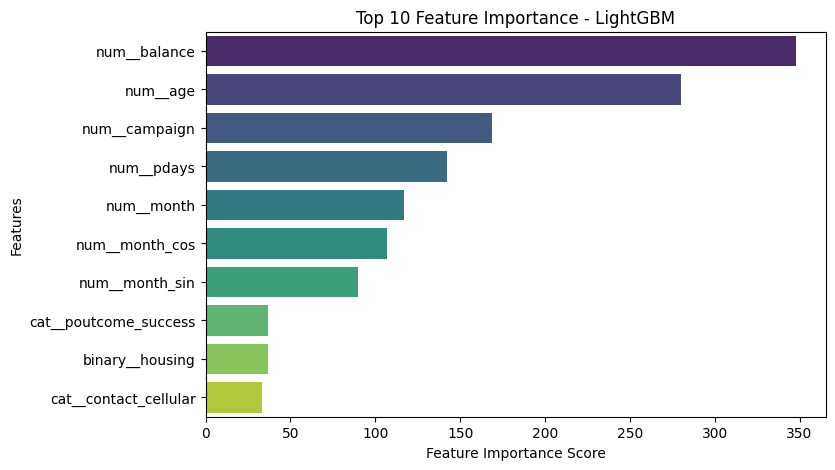

In [34]:
# Best Model from Grid Search
best_model = grid_search.best_estimator_

# Retrieve feature names
feature_names = X_train.columns

# Extract feature importance values from the model
feature_importance = best_model.named_steps['model'].feature_importances_

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort by feature importance
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df[:10], palette='viridis')  
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Feature Importance - LightGBM')
plt.show()


This code extracts the feature importance scores from the best LightGBM model obtained through Grid Search. Feature importance helps us understand which input variables contribute the most to the model's decision-making process.

1. The best model is retrieved from grid_search.best_estimator_, which represents the optimal hyperparameter combination.
2. The feature names are extracted from X_train.columns, ensuring we correctly label the importance values.
3. The model’s feature importances are obtained using .feature_importances_, which provides a score for each feature based on how much it influences the model’s predictions.
4. A DataFrame is created and sorted in descending order to prioritize the most influential features.
5. The top 10 most important features are visualized using a bar plot to highlight their significance in the LightGBM model.

This visualization helps in identifying key customer attributes that drive term deposit subscriptions, allowing banks to refine their marketing strategies by focusing on the most relevant factors.

In [35]:
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.71      0.72      0.72       751
           1       0.67      0.66      0.67       646

    accuracy                           0.69      1397
   macro avg       0.69      0.69      0.69      1397
weighted avg       0.69      0.69      0.69      1397



From the Classification Report for the Tuned LGBM model, we can observe the following:

- Recall for class 1 (customers who subscribed) = 66%
This is important since our main goal is maximizing customer acquisition, meaning we want to capture as many potential subscribers as possible.

- Precision for class 1 = 67%
This means that out of all the predicted subscribers, 67% were actually subscribers.

- F1-score is balanced at around 0.67 for class 1, indicating a good trade-off between precision and recall.

- Overall accuracy is 69%, but since our priority is recall, accuracy alone is not the main evaluation metric.



## Conclusion

After hyperparameter tuning, the optimized LightGBM model achieved an accuracy of 69%, with a precision of 71% for class 0 (non-subscribers) and 67% for class 1 (subscribers). More importantly, the recall for class 1 improved to 66%, ensuring that more potential customers were correctly identified. Given that our goal is to maximize recall to capture as many potential subscribers as possible, the tuned model offers a better balance between recall and precision compared to the default model.

Overall, the tuning process enhanced the model's effectiveness in predicting customer subscription behavior, making it a more reliable tool for targeted marketing campaigns.